### Load the DataFrame

In [21]:
import pandas as pd
import scipy.sparse as sp
import scipy.stats as stats
import scipy.sparse.linalg as spla
import sklearn.cluster
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

datasetfname = "uspto_grants_all_H_sections.hdf5"
try:
    df
except NameError:
    df = pd.read_hdf(datasetfname)
df.reset_index(inplace=True,drop=True)

### Produce an adjacency matrix where vertices are the patents (vertex i corresponds to row i of the dataset) and an edge indicates that vertices i and j have the relation cites or is cited by in the original dataset, or they share a cited patent that is or is not in the dataset

In [4]:
patentNums = df["publishedPatentDocNumber"].tolist()
applicantCitations = df["applicantCitations"].tolist()
examinerCitations = df["examinerCitations"].tolist()

uniqueCitations = set([])
for idx in xrange(len(applicantCitations)):
    uniqueCitations.update(applicantCitations[idx]) 
for idx in xrange(len(examinerCitations)):
    uniqueCitations.update(examinerCitations[idx])
    
vertexList = list(patentNums)
vertexList.extend(uniqueCitations)

docToVertexLUT = {}
for idx in xrange(len(vertexList)):
    docToVertexLUT[vertexList[idx]] = idx
    
# B = csr_matrix((data, indices, colIndexPointers)) will be a
# patents-by-numvertices adjacency matrix stored in CSR format
colIndexPointers = [0]*(len(patentNums)+1)
for rowNum in xrange(len(patentNums)):
    colIndexPointers[rowNum+1] = colIndexPointers[rowNum] + len(applicantCitations[rowNum]) + len(examinerCitations[rowNum])
    
indices = [0]*colIndexPointers[-1]
for rowNum in xrange(len(patentNums)):
    if (rowNum % 50000 == 0):
        print('Populating row {0} of {1}'.format(rowNum, len(patentNums)))
    citations = applicantCitations[rowNum]
    citations.extend(examinerCitations[rowNum])
    indices[colIndexPointers[rowNum]:colIndexPointers[rowNum+1]] = map(lambda doc: docToVertexLUT[doc], citations) 
    
data = [1]*len(indices)
B = sp.csr_matrix((data, indices, colIndexPointers))
C = np.dot(B, B.T)
C = C + C.T

Populating row 0 of 666137
Populating row 50000 of 666137
Populating row 100000 of 666137
Populating row 150000 of 666137
Populating row 200000 of 666137
Populating row 250000 of 666137
Populating row 300000 of 666137
Populating row 350000 of 666137
Populating row 400000 of 666137
Populating row 450000 of 666137
Populating row 500000 of 666137
Populating row 550000 of 666137
Populating row 600000 of 666137
Populating row 650000 of 666137


### Make C into a genuine adjacency matrix A

In [ ]:
(i,j,v) = sp.find(C)
for idx in xrange(len(v)):
    if i[idx] == j[idx]:
        v[idx] = 0
    else:
        v[idx] = 1.0
A = sp.coo_matrix((v, (i,j)), shape=C.shape, dtype='d').tocsr()

### Fit an SBM

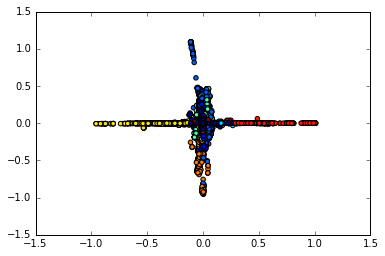

In [22]:
k = 10
(U,s,V) = spla.svds(A, k)
S = np.diagflat(np.sqrt(s))
Xhat = np.dot(U,S)
kmeans_obj = sklearn.cluster.KMeans(k, n_init=1, max_iter=10)
labels = kmeans_obj.fit_predict(Xhat)
plt.scatter(Xhat[:, 0], Xhat[:, 1], c=labels)

### Export the entire adjacency matrix

In [ ]:
adjacencymatfname = "one_hop_adjacency_all_H.txt"

def export_sparsemat(spmat, outfname):
    (i,j,v) = sp.find(spmat)
    with open(outfname, "w") as fout:
        for idx in xrange(len(i)):
            if (i[idx] == j[idx]):
                continue
            if (idx % 100000 == 0):
                print("Exporting edge {0} of {1}".format(idx+1, len(i)))
            fout.write("{0} {1}\n".format(i[idx], j[idx]))
export_sparsemat(C, adjacencymatfname)

### Export positive samples

In [34]:
numpositives = 15000
posexamplesIndices = np.random.choice(len(i), numpositives)
iPos = i[posexamplesIndices]
jPos = j[posexamplesIndices]
outfname = "positive_edges.txt"
with open(outfname, "w") as fout:
    for idx in xrange(numpositives):
        fout.write("{0} {1}\n".format(iPos[idx], jPos[idx]))
